In [85]:
!pip install scikit-learn
!pip install matplotlib

Python(61150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Python(61151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [86]:
!pip install optuna tensorflow


Python(61152) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [87]:
import numpy as np
import pandas as pd
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf


In [88]:
df = pd.read_csv('/Users/nguyentandat/Downloads/df.csv')

In [89]:
df.head()

,Date,Close,Open,High,Low,Volume,Change_pct,Usd/vnd,EMA20,EMA50,SMA20,SMA50,BB_Middle,BB_Upper,BB_Lower,BB_Width,RSI,MACD,Signal
0,2001-02-02,250.23,250.23,250.23,250.23,30.0,1.80,14541.0,216.479266,185.453670,214.2515,174.8240,214.2515,255.205117,173.297883,0.382295,100.000000,20.346353,18.419140
1,2001-02-07,259.93,259.93,259.93,259.93,10.0,1.95,14548.0,220.617431,188.374310,217.7510,177.6042,217.7510,261.801785,173.700215,0.404598,100.000000,21.317905,18.998893
2,2001-02-09,260.15,260.15,260.15,260.15,320.0,0.08,14551.0,224.382438,191.189043,221.5345,180.3844,221.5345,266.541303,176.527697,0.406319,100.000000,21.853704,19.569855
3,2001-02-12,256.18,256.18,256.18,256.18,130.0,-1.53,14549.0,227.410777,193.737708,224.9625,183.0638,224.9625,269.534741,180.390259,0.396264,93.070344,21.707749,19.997434
4,2001-02-14,252.21,252.21,252.21,252.21,80.0,-1.55,14552.0,229.772608,196.030739,228.0175,185.6214,228.0175,271.173340,184.861660,0.378531,86.198505,21.029320,20.203811


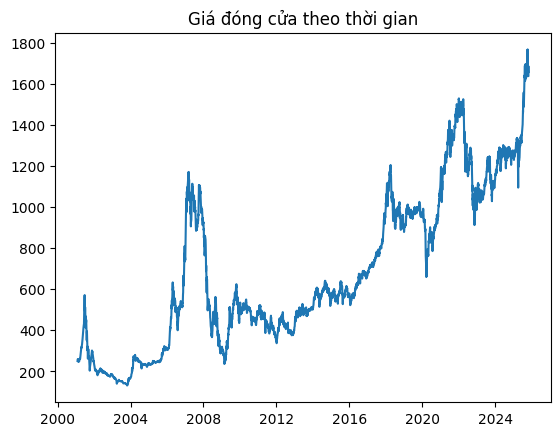

In [90]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Chỉ lấy 1 cột cần dự đoán
data = df[['Close']]
plt.plot(data)
plt.title("Giá đóng cửa theo thời gian")
plt.show()

In [91]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)



In [92]:
n_steps = 250  # số ngày nhìn lại

X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape về dạng [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [93]:
train_size = int(len(X) * 0.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [94]:
def objective(trial):
    # Số lớp LSTM: 2 hoặc 3
    n_layers = trial.suggest_int('n_layers', 2, 3)
    
    # Số units cho từng lớp
    units = [trial.suggest_int(f'n_units_l{i}', 32, 128, step=32) for i in range(n_layers)]
    
    # Dropout và learning rate
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.4, step=0.1)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Xây dựng mô hình LSTM nhiều lớp
    model = Sequential()
    
    # Lớp LSTM đầu tiên
    model.add(LSTM(units[0], return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(dropout_rate))
    
    # Lớp LSTM thứ 2
    model.add(LSTM(units[1], return_sequences=(n_layers == 3)))  # Nếu có lớp thứ 3 thì trả về sequences
    model.add(Dropout(dropout_rate))
    
    # Nếu có lớp LSTM thứ 3
    if n_layers == 3:
        model.add(LSTM(units[2]))
        model.add(Dropout(dropout_rate))
    
    # Dense layer
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Huấn luyện ngắn để đánh giá nhanh
    model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, verbose=0)

    # Đánh giá
    preds = model.predict(X_test, verbose=0)
    mse = mean_squared_error(y_test, preds)
    return mse


In [ ]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
print(f"MSE: {study.best_trial.value}")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-11-08 11:28:51,091] A new study created in memory with name: no-name-26b855c7-f02a-4534-9099-4938162c26ad
/var/folders/1c/h3mcrjs96pxbb_6hcly26ygm0000gn/T/ipykernel_58844/3227069581.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/Users/nguyentandat/.virtualenvs/r-keras/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-11-08 11:35:49,523] Trial 0 finished with value: 0.009057240445666323 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 32, 'dropout': 0.1, 'lr': 0.0002632043624149291, 'batch_size': 32}. Best is trial 0 with 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Tham số tối ưu từ Optuna
n_layers = 3
units = [128, 32, 64]
dropout = 0.1
lr = 0.0006581837105710621
batch_size = 16

# Xây dựng mô hình
model_best = Sequential()
model_best.add(LSTM(units[0], return_sequences=True, input_shape=(n_steps, 1)))
model_best.add(Dropout(dropout))

model_best.add(LSTM(units[1], return_sequences=True))
model_best.add(Dropout(dropout))

model_best.add(LSTM(units[2]))
model_best.add(Dropout(dropout))

model_best.add(Dense(25, activation='relu'))
model_best.add(Dense(1))

# Compile
opt = Adam(learning_rate=lr)
model_best.compile(optimizer=opt, loss='mean_squared_error')

# Huấn luyện kỹ hơn để khai thác tối đa
history = model_best.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.1, verbose=1)


/Users/nguyentandat/.virtualenvs/r-keras/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.1177 - val_loss: 0.0104
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0072 - val_loss: 0.0239
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 9/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 10/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 11/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 12/100
321/32

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dự đoán trên dữ liệu chuẩn hóa
preds_scaled = model_best.predict(X_test)

preds_scaled


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[1.4825166],
       [1.504105 ],
       [1.5313672],
       [1.5739299],
       [1.5649232],
       [1.5756611],
       [1.5621936],
       [1.5587538],
       [1.5601915],
       [1.5560158],
       [1.5627018],
       [1.5418023],
       [1.5239061],
       [1.5387366],
       [1.5169768],
       [1.4868792],
       [1.4853714],
       [1.4872807],
       [1.472661 ],
       [1.444824 ],
       [1.4961256],
       [1.5074549],
       [1.5245914],
       [1.5374727],
       [1.5268005],
       [1.5513102],
       [1.5761575],
       [1.583196 ],
       [1.5869873],
       [1.5811933],
       [1.5911258],
       [1.5774595],
       [1.5523505],
       [1.5349779],
       [1.5283965],
       [1.5291733],
       [1.5535623],
       [1.5658609],
       [1.5742245],
       [1.5740299],
       [1.5613815],
       [1.5576907],
       [1.5731586],
       [1.5667135],
       [1.5540813],
       [1.5321463],
       [1.532385 ],
       [1.4944574],
       [1.4819657],
       [1.4862602],


In [ ]:
# Đưa dự đoán và giá trị thật về dạng 2D (n_samples, 1)
preds_scaled = np.array(preds_scaled).reshape(-1, 1)
y_test_scaled = np.array(y_test).reshape(-1, 1)

# Đảo ngược scale về giá trị thực
preds_real = scaler.inverse_transform(preds_scaled)
y_test_real = scaler.inverse_transform(y_test_scaled)

# Tính MSE và MAE trên giá trị thực
mse_real = mean_squared_error(y_test_real, preds_real)
mae_real = mean_absolute_error(y_test_real, preds_real)

print(f"MSE trên giá trị thực: {mse_real:.6f}")
print(f"MAE trên giá trị thực: {mae_real:.6f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Final MSE: 0.012271
MAE: 0.063374
MAPE: 21.88%
R-squared: -496.782836


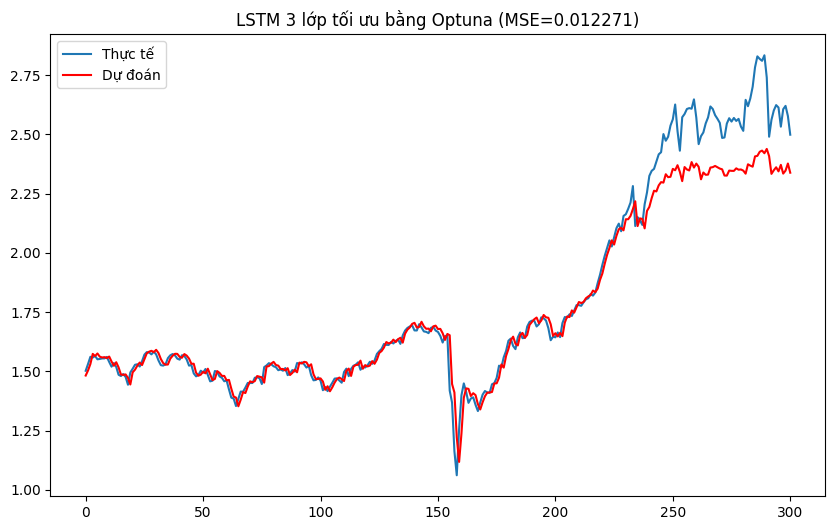

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán
preds = model_best.predict(X_test)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
r_square = 1 - (np.sum((y_test - preds) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"Final MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r_square:.6f}")

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Thực tế')
plt.plot(preds, label='Dự đoán', color='red')
plt.legend()
plt.title(f"LSTM 3 lớp tối ưu bằng Optuna (MSE={mse:.6f})")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

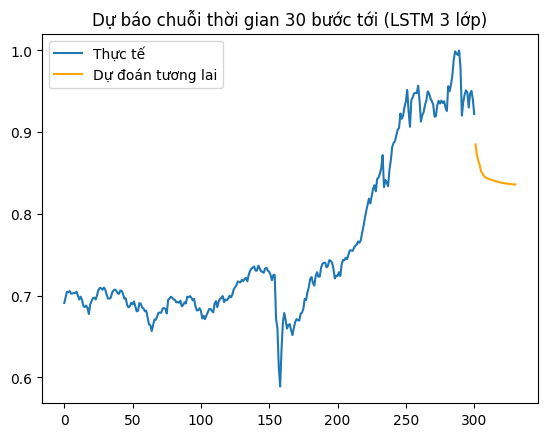

In [ ]:
future_steps = 30
current_seq = X_test[-1]
future_preds = []

for _ in range(future_steps):
    pred = model_best.predict(current_seq.reshape(1, n_steps, 1))[0, 0]
    future_preds.append(pred)
    current_seq = np.vstack([current_seq[1:], [pred]])

future_preds = np.array(future_preds).reshape(-1, 1)
future_preds_inv = scaler.inverse_transform(future_preds)

plt.plot(np.arange(len(y_test)), scaler.inverse_transform(y_test.reshape(-1,1)), label='Thực tế')
plt.plot(np.arange(len(y_test), len(y_test)+future_steps), future_preds_inv, label='Dự đoán tương lai', color='orange')
plt.legend()
plt.title("Dự báo chuỗi thời gian 30 bước tới (LSTM 3 lớp)")
plt.show()


In [ ]:
for i, layer in enumerate(model_best.layers):
    weights = layer.get_weights()
    print(f"Lớp {i} - {layer.name}: {[w.shape for w in weights]}")


Lớp 0 - lstm_55: [(1, 512), (128, 512), (512,)]
Lớp 1 - dropout_54: []
Lớp 2 - lstm_56: [(128, 128), (32, 128), (128,)]
Lớp 3 - dropout_55: []
Lớp 4 - lstm_57: [(32, 256), (64, 256), (256,)]
Lớp 5 - dropout_56: []
Lớp 6 - dense_44: [(64, 25), (25,)]
Lớp 7 - dense_45: [(25, 1), (1,)]
